In [1]:
import os
import sys
import timeit

import numpy

import theano
import theano.tensor as T
from theano.tensor.signal import downsample
from theano.tensor.nnet import conv2d

from logistic_sgd import LogisticRegression, load_data
from mlp import HiddenLayer

Using gpu device 5: GeForce GTX TITAN X (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 4007)
/home/schiang/Theano/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
class LeNetConvPoolLayer(object):
    """Pool Layer of a convolutional network """

    def __init__(self, rng, input, filter_shape, image_shape, poolsize=(2, 2), border_mode='valid'):
        """
        Allocate a LeNetConvPoolLayer with shared variable internal parameters.

        :type rng: numpy.random.RandomState
        :param rng: a random number generator used to initialize weights

        :type input: theano.tensor.dtensor4
        :param input: symbolic image tensor, of shape image_shape

        :type filter_shape: tuple or list of length 4
        :param filter_shape: (number of filters, num input feature maps,
                              filter height, filter width)

        :type image_shape: tuple or list of length 4
        :param image_shape: (batch size, num input feature maps,
                             image height, image width)

        :type poolsize: tuple or list of length 2
        :param poolsize: the downsampling (pooling) factor (#rows, #cols)
        """

        assert image_shape[1] == filter_shape[1]
        self.input = input

        # there are "num input feature maps * filter height * filter width"
        # inputs to each hidden unit
        fan_in = numpy.prod(filter_shape[1:])
        # each unit in the lower layer receives a gradient from:
        # "num output feature maps * filter height * filter width" /
        #   pooling size
        fan_out = (filter_shape[0] * numpy.prod(filter_shape[2:]) //
                   numpy.prod(poolsize))
        # initialize weights with random weights
        W_bound = numpy.sqrt(6. / (fan_in + fan_out))
        self.W = theano.shared(
            numpy.asarray(
                rng.uniform(low=-W_bound, high=W_bound, size=filter_shape),
                dtype=theano.config.floatX
            ),
            borrow=True
        )

        # the bias is a 1D tensor -- one bias per output feature map
        b_values = numpy.zeros((filter_shape[0],), dtype=theano.config.floatX)
        self.b = theano.shared(value=b_values, borrow=True)

        # convolve input feature maps with filters
        conv_out = conv2d(
            input=input,
            filters=self.W,
            filter_shape=filter_shape,
            input_shape=image_shape,
            border_mode=border_mode
        )

        # downsample each feature map individually, using maxpooling
        pooled_out = downsample.max_pool_2d(
            input=conv_out,
            ds=poolsize,
            ignore_border=True
        )

        # add the bias term. Since the bias is a vector (1D array), we first
        # reshape it to a tensor of shape (1, n_filters, 1, 1). Each bias will
        # thus be broadcasted across mini-batches and feature map
        # width & height
        self.output = T.nnet.relu(pooled_out + self.b.dimshuffle('x', 0, 'x', 'x'))

        # store parameters of this layer
        self.params = [self.W, self.b]

        # keep track of model input
        self.input = input

# Unpooling Function

In [3]:
class Unpooling2D(object):
    def __init__(self, input, poolsize=(2,2)):
        self.dtype=theano.config.floatX
        
        pooled_out = T.extra_ops.repeat(input, 2, axis=2)
        pooled_out = T.extra_ops.repeat(pooled_out, 2, axis=3)
        
        self.output = pooled_out
        self.input = input

# Loading MNIST data

In [4]:
dataset='data/mnist.pkl.gz'
batch_size=100
datasets = load_data(dataset)

train_set_x, train_set_y = datasets[0]
valid_set_x, valid_set_y = datasets[1]
test_set_x, test_set_y = datasets[2]

# compute number of minibatches for training, validation and testing
n_train_batches = train_set_x.get_value(borrow=True).shape[0]
n_valid_batches = valid_set_x.get_value(borrow=True).shape[0]
n_test_batches = test_set_x.get_value(borrow=True).shape[0]
n_train_batches //= batch_size
n_valid_batches //= batch_size
n_test_batches //= batch_size

... loading data


In [7]:
train_set_x.get_value().shape

(50000, 784)

In [5]:
train_set_x_out = train_set_x.reshape((train_set_x.shape[0], -1))
valid_set_x_out = valid_set_x.reshape((valid_set_x.shape[0], -1))
test_set_x_out = test_set_x.reshape((test_set_x.shape[0], -1))

# Input data visualization

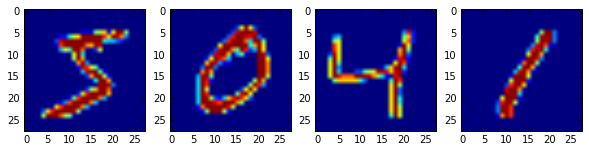

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10, 5))
ax1.imshow(train_set_x[0,:].eval().reshape(28, 28))
ax2.imshow(train_set_x[1,:].eval().reshape(28, 28))
ax3.imshow(train_set_x[2,:].eval().reshape(28, 28))
ax4.imshow(train_set_x[3,:].eval().reshape(28, 28))


# The actual deconvnet

In [19]:
learning_rate=0.00000005
n_epochs=50,
dataset='data/mnist.pkl.gz'
nkerns=[20, 50]
batch_size=100
""" Demonstrates lenet on MNIST dataset

:type learning_rate: float
:param learning_rate: learning rate used (factor for the stochastic
                      gradient)

:type n_epochs: int
:param n_epochs: maximal number of epochs to run the optimizer

:type dataset: string
:param dataset: path to the dataset used for training /testing (MNIST here)

:type nkerns: list of ints
:param nkerns: number of kernels on each layer
"""

rng = numpy.random.RandomState(23455)
num_filters = 16
filter_size = 3

# allocate symbolic variables for the data
index = T.lscalar()  # index to a [mini]batch

# start-snippet-1
x = T.matrix('x')   # the data is presented as rasterized images
y = T.matrix('y')  # the labels are presented as 1D vector of
                    # [int] labels

######################
# BUILD ACTUAL MODEL #
######################
print('... building the model')

# Reshape matrix of rasterized images of shape (batch_size, 28 * 28)
# to a 4D tensor, compatible with our LeNetConvPoolLayer
# (28, 28) is the size of MNIST images.
layer0_input = x.reshape((batch_size, 1, 28, 28))

# Construct the first convolutional pooling layer:
# filtering reduces the image size to (28-5+1 , 28-5+1) = (24, 24)
# maxpooling reduces this further to (24/2, 24/2) = (12, 12)
# 4D output tensor is thus of shape (batch_size, nkerns[0], 12, 12)
layer0 = LeNetConvPoolLayer(
    rng,
    input=layer0_input,
    image_shape=(batch_size, 1, 28, 28),
    filter_shape=(num_filters, 1, 5, 5),
    poolsize=(2, 2),
    border_mode='valid'
)

# Construct the second convolutional pooling layer
# filtering reduces the image size to (12-5+1, 12-5+1) = (8, 8)
# maxpooling reduces this further to (8/2, 8/2) = (4, 4)
# 4D output tensor is thus of shape (batch_size, nkerns[1], 4, 4)
layer1 = LeNetConvPoolLayer(
    rng,
    input=layer0.output,
    image_shape=(batch_size, num_filters, 12, 12),
    filter_shape=(num_filters*2, num_filters, 3, 3),
    poolsize=(2, 2),
    border_mode='valid'
)

# the HiddenLayer being fully-connected, it operates on 2D matrices of
# shape (batch_size, num_pixels) (i.e matrix of rasterized images).
# This will generate a matrix of shape (batch_size, nkerns[1] * 4 * 4),
# or (500, 50 * 4 * 4) = (500, 800) with the default values.
layer2_input = layer1.output.flatten(2)

# construct a fully-connected sigmoidal layer
layer2 = HiddenLayer(
    rng,
    input=layer2_input,
    n_in=num_filters*2 * 5 * 5,
    n_out=128,
    activation=T.nnet.relu
)

layer3 = HiddenLayer(
    rng, 
    input=layer2.output, 
    n_in=128,
    n_out=16,
    activation=T.nnet.relu
)

layer4 = HiddenLayer(
    rng, 
    input=layer3.output, 
    n_in=16, 
    n_out=128,
    activation=T.nnet.relu
)

layer5 = HiddenLayer(
    rng, 
    input=layer4.output, 
    n_in=128, 
    n_out=num_filters*2 * 5 * 5, 
    activation=T.nnet.relu
)

layer6_input = layer5.output.reshape((batch_size, num_filters*2, 5, 5))

#Unpooling layer
#Input (batch_size, 32, 5, 5)
#Upsamples to output (batch_size, 32, 10, 10)
layer6 = Unpooling2D(layer6_input)

#Takes a tensor(batch_size, 32, 10, 10)
#convolves by a 3 by 3 filter
#outputs(10 + 3 - 1) = 12
#a tensor of (batch_size, 16, 12, 12)
layer7 = LeNetConvPoolLayer(
    rng, 
    input=layer6.output, 
    image_shape=(batch_size, num_filters*2, 10, 10), 
    filter_shape=(num_filters, num_filters*2, 3, 3), 
    poolsize=(1,1), 
    border_mode='full'
)

#Upsamples from (batch_size, 16, 12, 12) to (batch_size, 16, 24, 24)
layer8 = Unpooling2D(layer7.output)

#Convolves by a 5x5 filter
#ouputs (batch_size, 1, 28, 28)
layer9 = LeNetConvPoolLayer(
    rng, 
    input=layer8.output, 
    image_shape=(batch_size, num_filters, 24, 24), 
    filter_shape=(1, num_filters, 5, 5), 
    poolsize=(1,1), 
    border_mode='full'
)

#Reshapeoutput
conv_output = layer9.output.reshape((batch_size, -1))
#conv_output = T.round(conv_output)

# the cost we minimize during training is the NLL of the model
#cost = T.sum(T.nnet.binary_crossentropy(conv_output, y))
l2 = 0.005
cost = T.sum(T.sqr(conv_output - y)) + l2 * 0.5 + (T.sum(layer0.W) + T.sum(layer1.W) + T.sum(layer2.W) + T.sum(layer3.W) + T.sum(layer4.W) + T.sum(layer5.W) + T.sum(layer7.W) + T.sum(layer9.W))

# create a function to compute the mistakes that are made by the model
test_model = theano.function(
    [index],
    T.mean(T.neq(conv_output, y)),
    givens={
        x: test_set_x[index * batch_size: (index + 1) * batch_size],
        y: test_set_x_out[index * batch_size: (index + 1) * batch_size]
    }
)

validate_model = theano.function(
    [index],
    T.mean(T.neq(conv_output, y)),
    givens={
        x: valid_set_x[index * batch_size: (index + 1) * batch_size],
        y: valid_set_x_out[index * batch_size: (index + 1) * batch_size]
    }
)

visualize_model = theano.function(
    [index], 
    conv_output, 
    givens={
        x: train_set_x[index * batch_size: (index + 1) * batch_size],
        y: train_set_x_out[index * batch_size: (index + 1) * batch_size]
    }
)

# create a list of all model parameters to be fit by gradient descent
params = layer3.params + layer2.params + layer1.params + layer0.params + layer4.params + layer5.params + layer7.params + layer9.params

# create a list of gradients for all model parameters
grads = T.grad(cost, params)

# train_model is a function that updates the model parameters by
# SGD Since this model has many parameters, it would be tedious to
# manually create an update rule for each model parameter. We thus
# create the updates list by automatically looping over all
# (params[i], grads[i]) pairs.
updates = [
    (param_i, param_i - learning_rate * grad_i)
    for param_i, grad_i in zip(params, grads)
]

train_model = theano.function(
    [index],
    cost,
    updates=updates,
    givens={
        x: train_set_x[index * batch_size: (index + 1) * batch_size],
        y: train_set_x_out[index * batch_size: (index + 1) * batch_size]
    }
)
# end-snippet-1

###############
# TRAIN MODEL #
###############
print('... training')
# early-stopping parameters
patience = 10000  # look as this many examples regardless
patience_increase = 2  # wait this much longer when a new best is
                       # found
improvement_threshold = 0.995  # a relative improvement of this much is
                               # considered significant
validation_frequency = min(n_train_batches, patience // 2)
                              # go through this many
                              # minibatche before checking the network
                              # on the validation set; in this case we
                              # check every epoch

best_validation_loss = numpy.inf
best_iter = 0
test_score = 0.
start_time = timeit.default_timer()

epoch = 0
done_looping = False

visualize = []

while (epoch < n_epochs) and (not done_looping):
    epoch = epoch + 1
    for minibatch_index in range(n_train_batches):

        iter = (epoch - 1) * n_train_batches + minibatch_index

        if iter % 100 == 0:
            print('training @ iter = ', iter)
        cost_ij = train_model(minibatch_index)

        if (iter + 1) % validation_frequency == 0:

            # compute zero-one loss on validation set
            validation_losses = [validate_model(i) for i
                                 in range(n_valid_batches)]
            this_validation_loss = numpy.mean(validation_losses)
            print('epoch %i, minibatch %i/%i, validation error %f %%' %
                  (epoch, minibatch_index + 1, n_train_batches,
                   this_validation_loss * 100.))
            print cost_ij

            # if we got the best validation score until now
            if this_validation_loss < best_validation_loss:

                #improve patience if loss improvement is good enough
                if this_validation_loss < best_validation_loss *  \
                   improvement_threshold:
                    patience = max(patience, iter * patience_increase)

                # save best validation score and iteration number
                best_validation_loss = this_validation_loss
                best_iter = iter

                # test it on the test set
                test_losses = [
                    test_model(i)
                    for i in range(n_test_batches)
                ]
                
                visualize = [
                    visualize_model(i)
                    for i in range(n_test_batches)
                ]
                
                test_score = numpy.mean(test_losses)
                print(('     epoch %i, minibatch %i/%i, test error of '
                       'best model %f %%') %
                      (epoch, minibatch_index + 1, n_train_batches,
                       test_score * 100.))

        if patience <= iter:
            done_looping = True
            break

end_time = timeit.default_timer()
print('Optimization complete.')
print('Best validation score of %f %% obtained at iteration %i, with test performance %f %%' % (best_validation_loss * 100., best_iter + 1, test_score * 100.))

... building the model
... training
('training @ iter = ', 0)
('training @ iter = ', 100)
('training @ iter = ', 200)
('training @ iter = ', 300)
('training @ iter = ', 400)
epoch 1, minibatch 500/500, validation error 100.000000 %
5984.44433594
     epoch 1, minibatch 500/500, test error of best model 100.000000 %
('training @ iter = ', 500)
('training @ iter = ', 600)
('training @ iter = ', 700)
('training @ iter = ', 800)
('training @ iter = ', 900)
epoch 2, minibatch 500/500, validation error 98.026594 %
5502.14257812
     epoch 2, minibatch 500/500, test error of best model 98.033559 %
('training @ iter = ', 1000)
('training @ iter = ', 1100)
('training @ iter = ', 1200)
('training @ iter = ', 1300)
('training @ iter = ', 1400)
epoch 3, minibatch 500/500, validation error 80.962143 %
5132.98681641
     epoch 3, minibatch 500/500, test error of best model 80.972245 %
('training @ iter = ', 1500)
('training @ iter = ', 1600)
('training @ iter = ', 1700)
('training @ iter = ', 1800)


/home/schiang/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


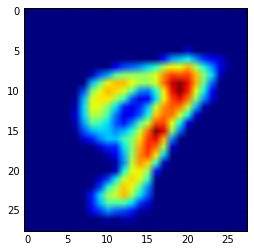

In [19]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.imshow((visualize[0][15].reshape(28,28)))

# Comparison of reconstructed data from deconv

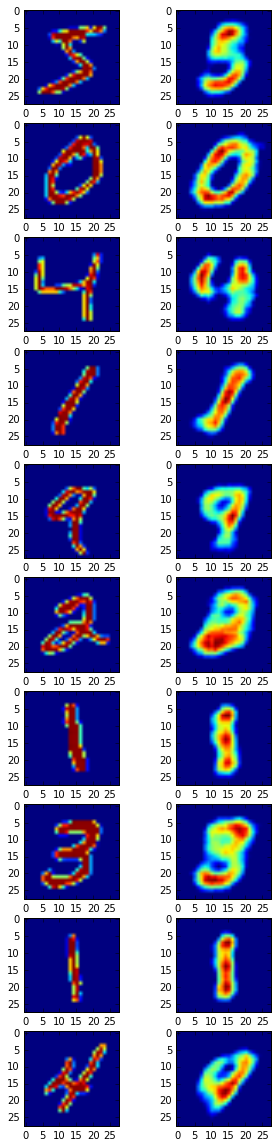

In [39]:
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10), (ax11, ax12), (ax13, ax14), (ax15, ax16), (ax17, ax18), (ax19, ax20)) = plt.subplots(10, 2, figsize=(5, 20))

ax1.imshow(train_set_x[0,:].eval().reshape(28, 28))
ax2.imshow(visualize[0][0].reshape(28,28))

ax3.imshow(train_set_x[1,:].eval().reshape(28, 28))
ax4.imshow(visualize[0][1].reshape(28,28))

ax5.imshow(train_set_x[2,:].eval().reshape(28, 28))
ax6.imshow(visualize[0][2].reshape(28,28))

ax7.imshow(train_set_x[3,:].eval().reshape(28, 28))
ax8.imshow(visualize[0][3].reshape(28,28))

ax9.imshow(train_set_x[4,:].eval().reshape(28, 28))
ax10.imshow(visualize[0][4].reshape(28,28))

ax11.imshow(train_set_x[5,:].eval().reshape(28, 28))
ax12.imshow(visualize[0][5].reshape(28,28))

ax13.imshow(train_set_x[6,:].eval().reshape(28, 28))
ax14.imshow(visualize[0][6].reshape(28,28))

ax15.imshow(train_set_x[7,:].eval().reshape(28, 28))
ax16.imshow(visualize[0][7].reshape(28,28))

ax17.imshow(train_set_x[8,:].eval().reshape(28, 28))
ax18.imshow(visualize[0][8].reshape(28,28))

ax19.imshow(train_set_x[9,:].eval().reshape(28, 28))
ax20.imshow(visualize[0][9].reshape(28,28))